# VGG19 Cats vs. Dogs

[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

In [61]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras import optimizers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.models import model_from_json
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image as im

/home/flo/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [62]:
%matplotlib inline

In [32]:
top_model_weights_path = 'first_try.h5'

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test/unknown'

# dimensions of our images.
img_width, img_height = 150, 150

# Found 24198 images belonging to 2 classes.
# Found 802 images belonging to 2 classes.
nb_train_samples = 24198
nb_validation_samples = 802

epochs = 5
batch_size = 16

In [3]:
base_model = applications.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width, img_height, 3))
print('Model Loaded')

Model Loaded


In [4]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [5]:
top_model.load_weights(top_model_weights_path)

In [6]:
# add the model on top of the convolutional base
model = Model(input=base_model.input, output=top_model(base_model.output))

/home/flo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  from ipykernel import kernelapp as app


In [7]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

In [8]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [9]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 24198 images belonging to 2 classes.
Found 802 images belonging to 2 classes.


In [10]:
model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)

Epoch 1/5


/home/flo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=5, validation_data=<keras.pre..., steps_per_epoch=1512, validation_steps=802)`


1512/1512 [==============================] - 210s - loss: 0.4750 - acc: 0.9050 - val_loss: 0.3697 - val_acc: 0.9250

In [12]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


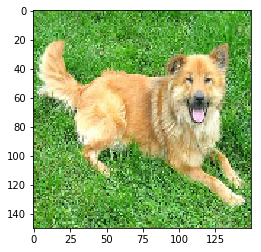

In [64]:
img_path = "data/test/unknown/4.jpg"
img = image.load_img(img_path, target_size=(img_width, img_height))
#img.show()
imshow(np.asarray(img))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)

In [57]:
print(preds)

[[ 1.]]
